# Ontology Enhanced PCA Model Final

### Importing Required Libraries for ESG PCA Analysis

This cell imports libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), PCA and imputation (scikit-learn), SPARQL querying, and clustering analysis.


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from SPARQLWrapper import SPARQLWrapper, JSON

### Querying ESG Knowledge Graph for the given metrics

This code connects to the GraphDB repository and executes a SPARQL query to retrieve ESG observations filtered based on metric, year and pillar for the respective industry.

In [106]:
"""
Parameters:
endpoint (str): Base URL of the GraphDB server.
repository (str): GraphDB repository name.
industry (str, optional): ESG industry filter.
metric_filter (str, optional): Substring to match in metric name.
pillar_filter (str, optional): Pillar value to filter on.
year (str): Year to filter.
model_name(str,optional): Model name to filter data with model.

Returns:
dict: SPARQL query results in JSON format.
"""

def query_esg_observations( endpoint, repository, industry, metric_filter, pillar_filter, year, model_name=None):

    sparql = SPARQLWrapper(f"{endpoint}/repositories/{repository}")

    query = """
    PREFIX ex: <http://example.org/esg#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT DISTINCT ?company ?year ?metric ?category ?value ?pillar ?unit ?model 
    WHERE {
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasCategory ?category ;
           ex:hasValue ?value ;
           ex:hasPillar ?pillar ;
           ex:hasUnit ?unit .
    """

    if industry:
        query += f"      ?obs ex:belongsToIndustry ex:{industry} .\n" 
    
    query += "      ?model ex:relatedToMetric ?metric .\n"
    
    if metric_filter:
        query += f'      FILTER(CONTAINS(STR(?metric), "{metric_filter}"))\n'
    if pillar_filter:
        query += f'      FILTER(STRAFTER(STR(?pillar), "#") = "{pillar_filter}")\n'
    if year:
        query += f'      FILTER(?year = "{year}"^^xsd:gYear)\n'

    query += "    } ORDER BY ?company ?year ?metric"

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

'\nParameters:\nendpoint (str): Base URL of the GraphDB server.\nrepository (str): GraphDB repository name.\nindustry (str, optional): ESG industry filter.\nmetric_filter (str, optional): Substring to match in metric name.\npillar_filter (str, optional): Pillar value to filter on.\nyear (str): Year to filter.\nmodel_name(str,optional): Model name to filter data with model.\n\nReturns:\ndict: SPARQL query results in JSON format.\n'

### Converting SPARQL Results to Structured Records

This block processes SPARQL query results into a list of structured records by extracting and cleaning fields like metric name, industry, category, and values for further analysis.


In [107]:
"""
Parameters:
results (dict): SPARQL query result in JSON format.
Returns:
List[Dict]: List of records with keys like company, year, metric, industry, etc.
"""

def parse_esg_results(results):
    records = []

    for result in results["results"]["bindings"]:
        # Extract full metric name
        metric_full = result["metric"]["value"].split("#")[-1]

        # split metric into metric_name and industry
        if "_" in metric_full:
            metric_parts = metric_full.rsplit("_", 1)
            metric_name = metric_parts[0]
            industry = metric_parts[1]
        else:
            metric_name = metric_full
            industry = "Unknown"

        record = {
            "company": result["company"]["value"].split("#")[-1],
            "year": result["year"]["value"],
            "metric": metric_name,
            "industry": industry,
            "category": result["category"]["value"].split("#")[-1],
            "value": float(result["value"]["value"]),
            "pillar": result["pillar"]["value"].split("#")[-1],
            "unit": result["unit"]["value"],
            "model": result["model"]["value"].split("#")[-1]
        }
        records.append(record)

    return records


'\nParameters:\nresults (dict): SPARQL query result in JSON format.\nReturns:\nList[Dict]: List of records with keys like company, year, metric, industry, etc.\n'

### Preparing Pivot Table for PCA Input

Defines a function to filter ESG records by model name and transform them into a pivot table format with companies as rows and ESG categories as columns, removing columns with excessive missing data.


In [108]:
"""
Parameters:
records (list): List of ESG records (dicts).
model_name (str): The model name to filter on (e.g., 'ghg_emissions_model').
Maximum allowed missing value ratio per column (missing threshold is 0.9 = 90%).

Returns:
pd.DataFrame: Filtered pivot table with categories as columns and companies as rows.
"""

def prepare_pivot_table(records, model_name, miss_threshold=0.9):

    # Convert to DataFrame
    df = pd.DataFrame(records)
    # Filter for the given model
    filtered_df = df[df['model'] == model_name]
    # Pivot: companies as rows, categories as columns
    pivot_df = filtered_df.pivot_table(
        index='company',
        columns='category',
        values='value',
        aggfunc='sum'
    )
    # Drop columns with >threshold missing
    missing_ratio = pivot_df.isna().mean()
    pivot_df_filtered = pivot_df.loc[:, missing_ratio < miss_threshold]

    return pivot_df_filtered

"\nParameters:\nrecords (list): List of ESG records (dicts).\nmodel_name (str): The model name to filter on (e.g., 'ghg_emissions_model').\nMaximum allowed missing value ratio per column (missing threshold is 0.9 = 90%).\n\nReturns:\npd.DataFrame: Filtered pivot table with categories as columns and companies as rows.\n"

### Analyzing Imputation Strategy per Metric

This function assesses missing value ratios and skewness for each metric, recommending an appropriate imputation method (mean, median, or KNN) based on defined thresholds.

In [109]:
"""
Parameters: 
df (pd.DataFrame): Input DataFrame with numeric columns to be analyzed for missing values and skewness.
missing_thresholds (tuple of float): If the column has less than 10%(0.1) missing data and low skewness, it qualifies for mean imputation,
- If the column has between 10%(0.1) and 30%(0.3) missing values, regardless of skew, it qualifies for median imputation.
- otherwise use KNN.
skew_threshold (float): If the absolute skewness < 1, the data is considered reasonably symmetric we use mean.
- If skewness is high, median or KNN is more robust.

Returns:
pd.DataFrame: Summary of imputation strategy with columns for metric, missing values, skew, selected method, and selected k.
"""

def analyze_impute_strategy(df, missing_thresholds=(0.1, 0.3), skew_threshold=1.0):
    result = []

    for col in df.columns:
        col_data = df[col]
        miss_ratio = col_data.isna().mean()
        skewness = col_data.dropna().skew()

        if miss_ratio < missing_thresholds[0] and abs(skewness) < skew_threshold:
            method = 'mean'
        elif miss_ratio < missing_thresholds[1]:
            method = 'median'
        else:
            method = 'knn'

        result.append({
            'metric': col,
            'missing_vals': round(miss_ratio * 100, 2),
            'skew': round(skewness, 3),
            'selected_method': method,
            'selected_k': None  # will be filled if KNN is used
        })

    return pd.DataFrame(result)

'\nParameters: \ndf (pd.DataFrame): Input DataFrame with numeric columns to be analyzed for missing values and skewness.\nmissing_thresholds (tuple of float): If the column has less than 10%(0.1) missing data and low skewness, it qualifies for mean imputation,\n- If the column has between 10%(0.1) and 30%(0.3) missing values, regardless of skew, it qualifies for median imputation.\n- otherwise use KNN.\nskew_threshold (float): If the absolute skewness < 1, the data is considered reasonably symmetric we use mean.\n- If skewness is high, median or KNN is more robust.\n\nReturns:\npd.DataFrame: Summary of imputation strategy with columns for metric, missing values, skew, selected method, and selected k.\n'

### Per-Metric Imputation with KNN Selection

This function imputes missing values per metric using a strategy based on missingness and skewness, and applies KNN imputation with optimal `k` for high-missing columns using Mean Absolute Deviation for selection.


In [110]:
"""
Parameters:
df (pd.DataFrame): Input DataFrame with numerical features and missing values.
knn_candidates (list of int, optional): List of neighbor values to try for KNN imputation. The best K is selected per metric using Mean Absolute Deviation (MAD) as the selection criterion.

Returns:
imputed_df (pd.DataFrame): DataFrame with missing values imputed using mean, median, or best KNN.
impute_strategy (pd.DataFrame): Summary DataFrame that shows:
- 'metric': Name of the column
- 'missing_vals': % of missing values
- 'skew': Skewness of the metric
- 'selected_method': Chosen imputation method ('mean', 'median', 'knn')
- 'selected_k': Best selected K (only for 'knn' methods, else None)
"""

def impute_per_metric(df, knn_candidates=[3, 5, 7]):

    impute_strategy = analyze_impute_strategy(df)
    imputed_df = df.copy()

    print(" Per-Metric Imputation Strategy \n")

    for i, row in impute_strategy.iterrows():
        col = row['metric']
        method = row['selected_method']
        missing = row['missing_vals']
        skew = row['skew']

        if method == 'mean':
            reason = "low skew & low missing values"
            imputed_df[col] = imputed_df[col].fillna(imputed_df[col].mean())
        elif method == 'median':
            reason = "moderate missing or skew"
            imputed_df[col] = imputed_df[col].fillna(imputed_df[col].median())
        else:
            reason = "high missing values (KNN candidate)"

        print(f"{col}: missing = {missing}%, skew = {skew} → using {method} method ({reason})")

    # KNN per metric 
    knn_cols = impute_strategy[impute_strategy['selected_method'] == 'knn']['metric'].tolist()
    if knn_cols:
        print("\n Performing per-metric KNN selection")

        for col in knn_cols:
            best_var = -np.inf
            best_k = None
            best_result = None

            print(f"\n Evaluating KNN for: {col}")
            for k in knn_candidates:
                imputer = KNNImputer(n_neighbors=k)
                knn_input = imputed_df.select_dtypes(include=[np.number])
                imputed_all = imputer.fit_transform(knn_input)
                imputed_all_df = pd.DataFrame(imputed_all, columns=knn_input.columns, index=imputed_df.index)
                
                result_col = imputed_all_df[[col]]

                # Compute Mean Absolute Deviation of the result column
                mad_score = (result_col - result_col.mean()).abs().mean().sum()

                print(f"   KNN(k={k}) → Mean Absolute Deviation = {mad_score:.2f}")

                # Prefer higher score, and smaller k in tie
                if mad_score > best_var or (mad_score == best_var and (best_k is None or k < best_k)):
                    best_k = k
                    best_result = result_col
                    best_var = mad_score

            #  Store imputed column and selected k
            imputed_df[col] = best_result
            impute_strategy.loc[impute_strategy['metric'] == col, 'selected_k'] = best_k
            print(f" {col}: Best k = {best_k}")

    return imputed_df, impute_strategy


"\nParameters:\ndf (pd.DataFrame): Input DataFrame with numerical features and missing values.\nknn_candidates (list of int, optional): List of neighbor values to try for KNN imputation. The best K is selected per metric using Mean Absolute Deviation (MAD) as the selection criterion.\n\nReturns:\nimputed_df (pd.DataFrame): DataFrame with missing values imputed using mean, median, or best KNN.\nimpute_strategy (pd.DataFrame): Summary DataFrame that shows:\n- 'metric': Name of the column\n- 'missing_vals': % of missing values\n- 'skew': Skewness of the metric\n- 'selected_method': Chosen imputation method ('mean', 'median', 'knn')\n- 'selected_k': Best selected K (only for 'knn' methods, else None)\n"

### Running PCA on Scaled ESG Data

This function runs PCA on the given DataFrame and selects the minimum number of components that captures at least 70% of the total variance.

In [111]:
"""
Parameters:
df (pd.DataFrame): Input data with numerical features.
Returns:
tuple: (PCA object, PCA scores as ndarray)
"""
def run_pca(df, threshold=0.7):
    # Standardize the data
    scaled = StandardScaler().fit_transform(df)

    # Initial PCA to determine explained variance
    temp_pca = PCA()
    temp_pca.fit(scaled)

    # Compute cumulative variance
    cum_variance = np.cumsum(temp_pca.explained_variance_ratio_)
    n_components = np.argmax(cum_variance >= threshold) + 1 

    # Final PCA with selected number of components
    pca = PCA(n_components=n_components)
    scores = pca.fit_transform(scaled)
    return pca, scores

'\nParameters:\ndf (pd.DataFrame): Input data with numerical features.\nReturns:\ntuple: (PCA object, PCA scores as ndarray)\n'

### Complete PCA Workflow with Imputation

This function performs missing value imputation followed by PCA, returning the PCA model, scores, and the imputed dataset for downstream analysis.


In [112]:
""" 
Parameters:
pivot table (pd.DataFrame): Filtered pivot table with categories as columns and companies as rows
Returns:
Tuple[PCA, np.ndarray, pd.DataFrame]: Fitted PCA object, PCA scores, and final imputed data.
"""
def pca_workflow(pivot_df_table):
    imputed_df, _ = impute_per_metric(pivot_df_table)
    imputed_df_numeric = imputed_df.select_dtypes(include=[np.number])
    pca, scores = run_pca(imputed_df_numeric)
    return pca, scores, imputed_df

' \nParameters:\npivot table (pd.DataFrame): Filtered pivot table with categories as columns and companies as rows\nReturns:\nTuple[PCA, np.ndarray, pd.DataFrame]: Fitted PCA object, PCA scores, and final imputed data.\n'

### Plotting Scree Plot with Variance Threshold

This function visualizes the explained and cumulative variance of PCA components, highlighting the number of components needed to reach a specified variance threshold.


In [113]:
"""
Parameters:
pca (PCA): Fitted PCA object.
threshold (float): Variance threshold line to plot (default: 0.7 for 70%).
"""

def plot_scree(pca):

    explained = pca.explained_variance_ratio_
    cum_explained = explained.cumsum()
    num_components = (cum_explained >= 0.7).argmax() + 1

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained)+1), explained, marker='o', label='Explained Variance')
    plt.plot(range(1, len(cum_explained)+1), cum_explained, marker='s', label='Cumulative Variance')
    plt.axhline(y=0.7, color='red', linestyle='--', label=f'{int(0.7*100)}% Threshold (PC{num_components})')

    plt.title("Scree Plot - PCA Explained Variance")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

'\nParameters:\npca (PCA): Fitted PCA object.\nthreshold (float): Variance threshold line to plot (default: 0.7 for 70%).\n'

### Extracting Top Contributing Features to PCA

This function calculates and returns the top N features with the highest loading magnitudes across principal components, indicating their influence on the PCA directions.


In [114]:
"""
Parameters:
pca (PCA): Fitted PCA object.
df (pd.DataFrame): Input data used for PCA.
top_n (int): Number of top features to return.
ascending (bool): Sort order by loading magnitude (default is descending).

Returns:
pd.DataFrame: Sorted DataFrame of top loadings by magnitude.
"""

def get_top_pca_loadings(pca, df, top_n=10):
    loadings = pd.DataFrame(
        pca.components_.T,
        index=df.columns,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    # Compute vector magnitude and sort
    loadings['magnitude'] = np.sqrt((loadings**2).sum(axis=1))
    sorted_top = loadings.sort_values(by='magnitude', ascending=True).head(top_n) #top 10 loading values

    return sorted_top.drop(columns='magnitude')


'\nParameters:\npca (PCA): Fitted PCA object.\ndf (pd.DataFrame): Input data used for PCA.\ntop_n (int): Number of top features to return.\nascending (bool): Sort order by loading magnitude (default is descending).\n\nReturns:\npd.DataFrame: Sorted DataFrame of top loadings by magnitude.\n'

### Visualizing Top PCA Loadings as Heatmap

This function plots a heatmap of the top feature loadings across principal components to highlight which features most influence each PC direction.


In [115]:
"""
Parameters:
top_loadings (pd.DataFrame): Loadings DataFrame (features x PCs).
"""
def plot_pca_loadings_heatmap(top_loadings):
    plt.figure(figsize=(10, len(top_loadings) * 0.5))
    sns.heatmap(top_loadings, annot=True, cmap='coolwarm', center=0)
    plt.title("Top Feature Contributions to Principal Components")
    plt.tight_layout()
    plt.show()


'\nParameters:\ntop_loadings (pd.DataFrame): Loadings DataFrame (features x PCs).\n'

### PCA Biplot Visualization with Feature Arrows

This function generates a PCA biplot showing company scores and feature contributions as arrows between two selected principal components, with labels and a summary legend.


In [116]:
"""
Parameters:
pca (PCA): Fitted PCA object.
scores (ndarray): PCA-transformed company scores.
df (pd.DataFrame): Input DataFrame (for feature names).
pc_x (int): Principal Component for x-axis (1-based).
pc_y (int): Principal Component for y-axis (1-based).
arrow_scale (float): Scale multiplier for loading vectors.
label_offset (float): Offset multiplier for text from arrow tips.
"""

def plot_biplot(pca, scores, df, pc_x=1, pc_y=2, arrow_scale=4.0, label_offset=1.3):

    pcx, pcy = pc_x - 1, pc_y - 1
    features = df.columns

    plt.figure(figsize=(10, 6))
    plt.scatter(scores[:, pcx], scores[:, pcy], alpha=0.6, label='Companies')

    # Arrow + inline label
    for i, feature in enumerate(features):
        x_loading = pca.components_[pcx, i] * arrow_scale
        y_loading = pca.components_[pcy, i] * arrow_scale
        plt.arrow(0, 0, x_loading, y_loading, color='red', alpha=0.6,
                  head_width=0.15, head_length=0.2)
        plt.text(x_loading * label_offset, y_loading * label_offset,
                 feature, fontsize=10, ha='center', va='center', color='black')

    # Label box in corner
    label_text = "\n".join([f"• {feat}" for feat in features])
    props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.95)
    plt.text(1.05, 0.95, label_text, transform=plt.gca().transAxes,
             fontsize=10, va='top', bbox=props)

    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.axvline(0, color='gray', lw=1, linestyle='--')
    plt.xlabel(f'PC{pc_x}') 
    plt.ylabel(f'PC{pc_y}')
    plt.title(f'PCA Biplot: PC{pc_x} vs PC{pc_y} with All Feature Labels')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


'\nParameters:\npca (PCA): Fitted PCA object.\nscores (ndarray): PCA-transformed company scores.\ndf (pd.DataFrame): Input DataFrame (for feature names).\npc_x (int): Principal Component for x-axis (1-based).\npc_y (int): Principal Component for y-axis (1-based).\narrow_scale (float): Scale multiplier for loading vectors.\nlabel_offset (float): Offset multiplier for text from arrow tips.\n'

### Identifying Top Metric Categories by PCA Importance

This function calculates feature importance scores from PCA loadings and returns the top contributing ESG metrics, optionally displaying their percentage contributions.<br>
For each metric (feature), we compute the Euclidean norm (vector magnitude) of its loading values across all principal components:

$$
\text{Importance}_{\text{metric}} = \sqrt{(\text{PC}_1)^2 + (\text{PC}_2)^2 + \cdots + (\text{PC}_n)^2}
$$
 

This gives us a single importance score for each metric, representing its overall influence across the PCA projection space.

In [117]:
"""
Parameters:
top_loadings (pd.DataFrame): PCA loading matrix (features x PCs).
top_n (int): Number of top metrics to return.
as_percent (bool): Whether to include relative magnitude in % format.

Returns:
pd.DataFrame: Top N metrics sorted by total influence magnitude.
"""

def get_top_metric_categories(top_loadings, top_n=5, as_percent=True):

    # Compute magnitude across PCs
    magnitudes = np.sqrt((top_loadings**2).sum(axis=1))
    total = magnitudes.sum()

    # Create DataFrame
    result = pd.DataFrame({
        'metric': magnitudes.index,
        'importance_score': magnitudes.values
    })

    # Add % contribution
    if as_percent:
        result['importance_percent'] = (result['importance_score'] / total * 100).round(2).astype(str) + '%'

    # Return top N
    return result.sort_values(by='importance_score', ascending=False).head(top_n).reset_index(drop=True)



'\nParameters:\ntop_loadings (pd.DataFrame): PCA loading matrix (features x PCs).\ntop_n (int): Number of top metrics to return.\nas_percent (bool): Whether to include relative magnitude in % format.\n\nReturns:\npd.DataFrame: Top N metrics sorted by total influence magnitude.\n'

# Call functions with parameters

In [ ]:
# Fetching ESG Observations with Custom Query Parameters
results = query_esg_observations(
    endpoint="http://host.docker.internal:7200", # this is the end point for running inside docker
    # endpoint="http://localhost:7200", # this is the end point for running locally
    
    repository="esg_repo",
    
    industry="biotechnology_pharmaceuticals",
    metric_filter="ghg_emissions",
    pillar_filter="e_risk",
    year="2022",
    model_name="ghg_emissions_model"
)

In [119]:
# Parsing SPARQL Query Results into Structured Records
records = parse_esg_results(results)

In [120]:
# Creating Pivot Table from Parsed ESG Records
pivot_df = prepare_pivot_table(records, model_name="ghg_emissions_model")

KeyError: 'model'

In [ ]:
# Running PCA Workflow on Pivot Table
pca, scores, imputed_df = pca_workflow(pivot_df)

 Per-Metric Imputation Strategy 

policy_emissions: missing = 41.55%, skew = -0.701 → using knn method (high missing values (KNN candidate))
targets_emissions: missing = 32.39%, skew = 2.633 → using knn method (high missing values (KNN candidate))

 Performing per-metric KNN selection

 Evaluating KNN for: policy_emissions
   KNN(k=3) → Mean Absolute Deviation = 0.38
   KNN(k=5) → Mean Absolute Deviation = 0.29
   KNN(k=7) → Mean Absolute Deviation = 0.27
 policy_emissions: Best k = 3

 Evaluating KNN for: targets_emissions
   KNN(k=3) → Mean Absolute Deviation = 0.13
   KNN(k=5) → Mean Absolute Deviation = 0.22
   KNN(k=7) → Mean Absolute Deviation = 0.23
 targets_emissions: Best k = 7


In [ ]:
explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()
num_components = (cum_explained >= 0.7).argmax() + 1

print(cum_explained)
print(len(cum_explained))

[0.28422777 0.47660787 0.62735805 0.75899079]
4


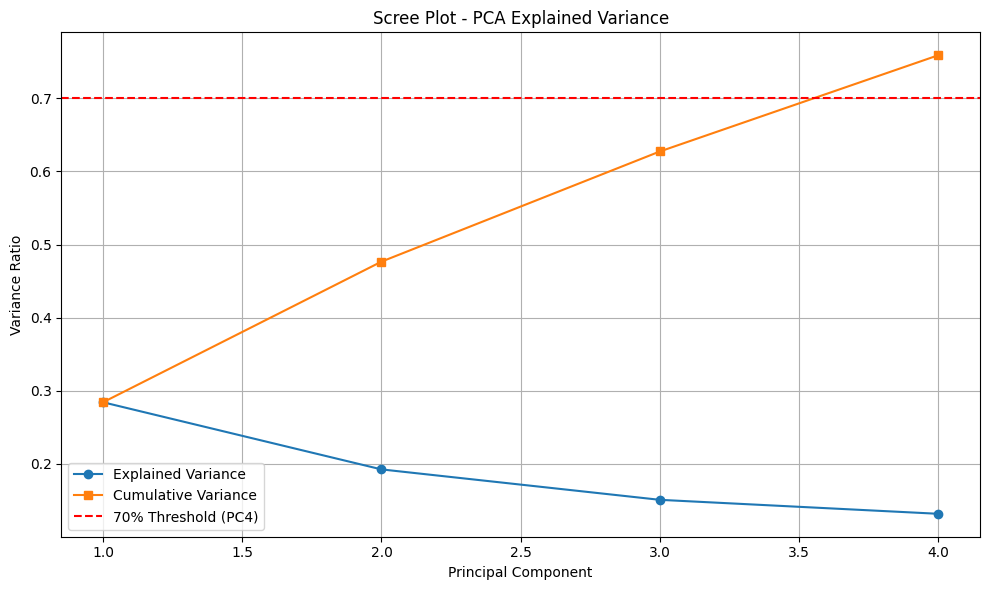

In [ ]:
# Scree plot of PCA
plot_scree(pca)

In [ ]:
# Extracting Top Feature Loadings from PCA
top_loadings = get_top_pca_loadings(pca, imputed_df)

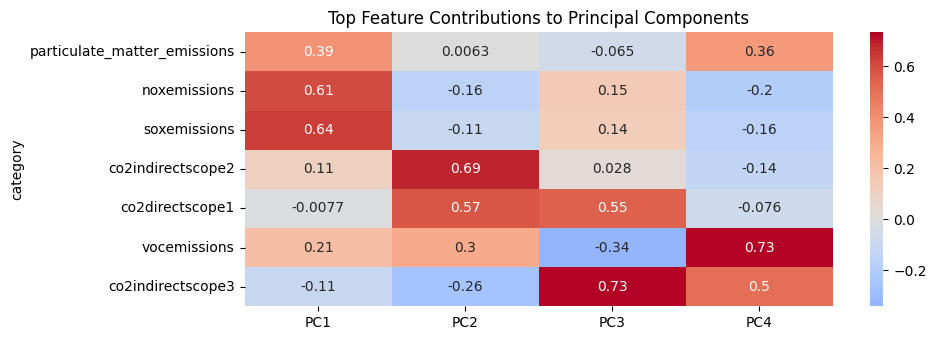

In [ ]:
# Plotting Heatmap for multiple PCs
plot_pca_loadings_heatmap(top_loadings)      

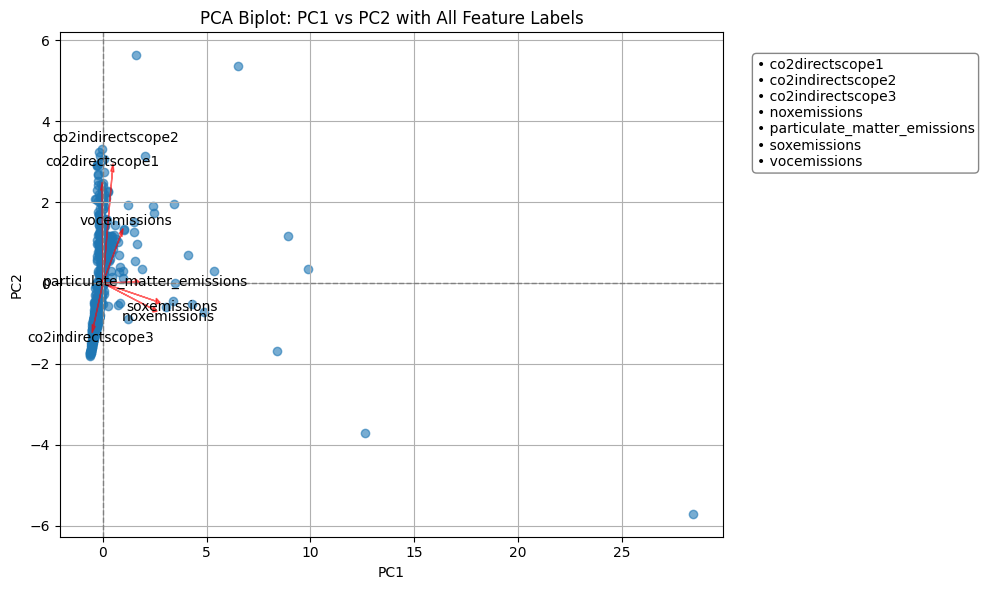

In [ ]:
 # Plotting biplot for PCs
plot_biplot(pca, scores, imputed_df)

In [ ]:
# Identifying Top ESG Metric Categories by PCA influence
top_metrics = get_top_metric_categories(top_loadings)

print("Top ESG categories for user selection:")
print(top_metrics)


Top ESG categories for user selection:
              metric  importance_score importance_percent
0  co2indirectscope3          0.933576             17.89%
1       vocemissions          0.881297             16.89%
2    co2directscope1          0.797115             15.28%
3  co2indirectscope2          0.711538             13.64%
4       soxemissions          0.683321              13.1%


## Export Notebook to .PY File (for frontend)

In [ ]:
'''
from nbconvert import PythonExporter
import nbformat

def convert_notebook_to_py(notebook_path, script_path):
    nb = nbformat.read(open(notebook_path), as_version=4)
    exporter = PythonExporter()
    source, _ = exporter.from_notebook_node(nb)

    with open(script_path, 'w', encoding='utf-8') as f:
        f.write(source)

# Example usage
convert_notebook_to_py("Ontology_PCA.ipynb", "../backend/functions/Ontology_PCA.py")
'''